In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from keras.applications import ResNet50
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define your dataset directories
train_data_dir = "/content/drive/MyDrive/models/train"
validation_data_dir = "/content/drive/MyDrive/models/val"
batch_size = 32
target_size = (224, 224)

# Load pre-trained ResNet50 model with top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

num_classes = 20  # Number of classes in ImageNet

# Create a custom top for the model
x = base_model.layers[-2].output  # Use the second-to-last layer as the base
x = layers.Dense(num_classes, activation='softmax')(x)

# Create the final fine-tuned model
model = models.Model(inputs=base_model.input, outputs=x)

# Compile the model with additional metrics
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(name='auc')])

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    # callbacks=[early_stopping]
)

# Save the model and weights
model.save('fine_tuned_resnet50_sgd.h5')

# Evaluate the model on the validation set
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)

# Convert predictions to class indices
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Calculate additional metrics
classification_report_str = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys(), zero_division=1)

# Print the classification report
print(classification_report_str)


Found 1477 images belonging to 20 classes.
Found 1449 images belonging to 20 classes.
Epoch 1/200
46/46 [==============================] - 1910s 42s/step - loss: 3.0077 - accuracy: 0.1045 - precision_1: 0.0625 - recall_1: 0.0014 - auc: 0.5961 - val_loss: 3.2158 - val_accuracy: 0.0875 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc: 0.5795
Epoch 2/200
46/46 [==============================] - 17s 370ms/step - loss: 2.9716 - accuracy: 0.1246 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc: 0.6086 - val_loss: 3.0174 - val_accuracy: 0.0951 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc: 0.5752
Epoch 3/200
46/46 [==============================] - 19s 422ms/step - loss: 2.9879 - accuracy: 0.1142 - precision_1: 0.0294 - recall_1: 6.9204e-04 - auc: 0.6091 - val_loss: 3.0070 - val_accuracy: 0.1111 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc: 0.5868
Epoch 4/200
46/46 [==============================] - 18s 383ms/step - loss: 2.92

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 12s 233ms/step
              precision    recall  f1-score   support

   aeroplane       0.08      0.13      0.10        90
     bicycle       0.00      0.00      0.00        73
        bird       0.00      0.00      0.00        98
        boat       0.00      0.00      0.00        68
      bottle       1.00      0.00      0.00        67
         bus       0.05      0.06      0.05        69
         car       0.00      0.00      0.00        66
         cat       0.07      0.20      0.11       114
       chair       1.00      0.00      0.00        53
         cow       1.00      0.00      0.00        71
 diningtable       1.00      0.00      0.00        28
         dog       1.00      0.00      0.00       119
       horse       1.00      0.00      0.00        75
   motorbike       0.03      0.01      0.02        70
      person       0.08      0.44      0.13       127
 pottedplant       1.00      0.00      0.00        33
       sheep       0.00  

46/46 [==============================] - 9s 203ms/step


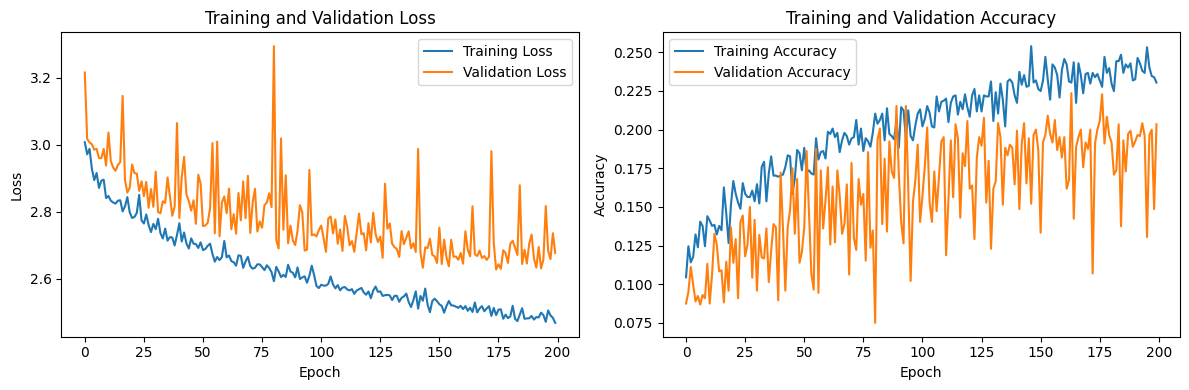

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.0277
Precision: 0.0246
Recall: 0.0594


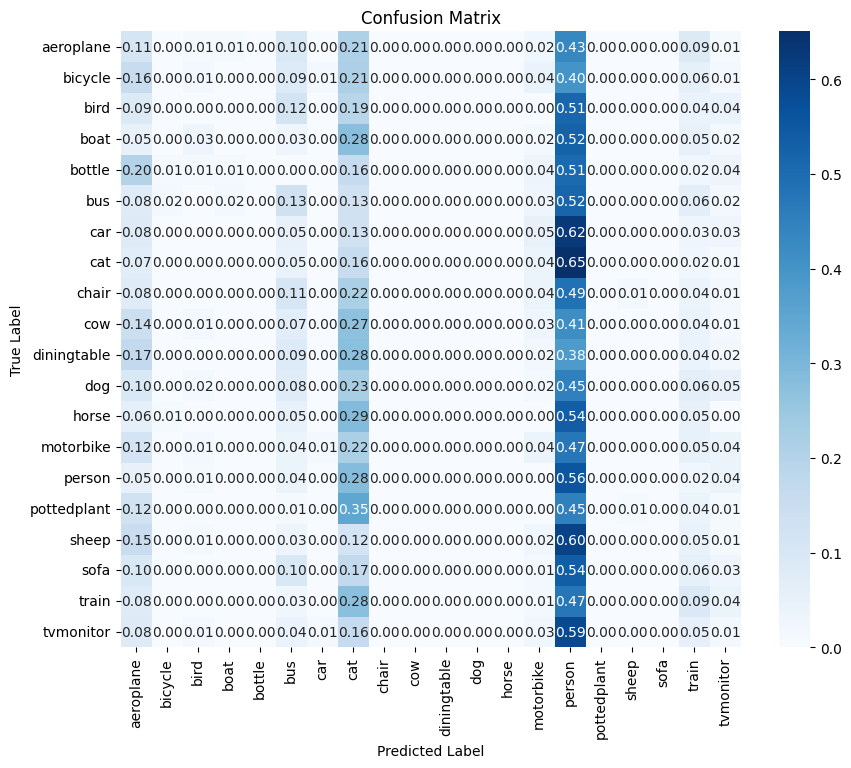

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import load_model

def plot_metrics(history):
    # Plot training loss vs validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return f1, precision, recall

def plot_heatmap(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Uncomment the next line if you want to load the model from the saved file
# model = load_model('fine_tuned_resnet50.h5')

# Example: Assuming you have a list of true labels and predicted labels
# You need to replace this with your actual labels
y_true_example = np.random.randint(0, num_classes, size=(validation_generator.samples,))
y_pred_example = model.predict(validation_generator)
y_pred_classes_example = np.argmax(y_pred_example, axis=1)

# Plot training metrics
plot_metrics(history)

# Calculate and print additional metrics
f1, precision, recall = calculate_metrics(y_true_example, y_pred_classes_example)
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot confusion matrix
class_names = list(validation_generator.class_indices.keys())
plot_heatmap(y_true_example, y_pred_classes_example, class_names)


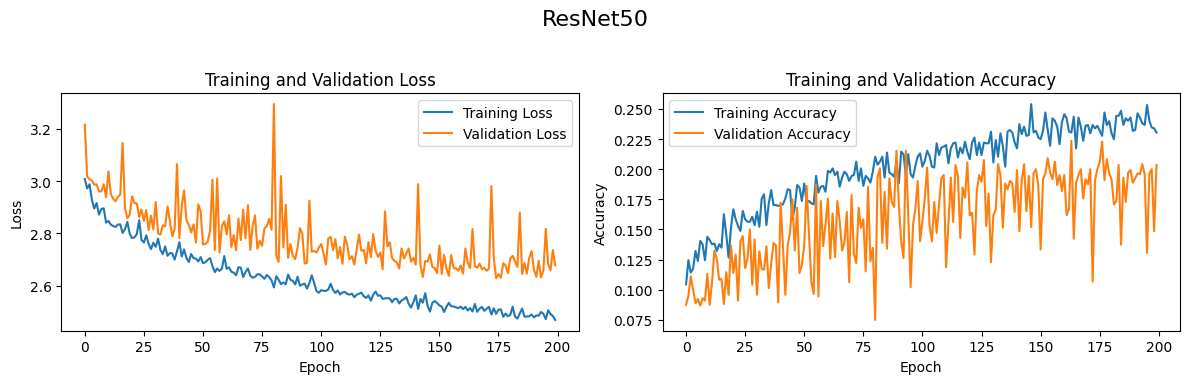

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import load_model

def plot_metrics(history):
    # Plot training loss vs validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle('ResNet50', fontsize=16)  # Overall title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    plt.show()

plot_metrics(history)
# Rest of the script remains unchanged
